In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## ETSP using SOM functions

In [3]:
def plot_cities(X, W, it=0):
    plt.scatter(X[:,0], X[:,1], color='darkred', label='cities')
    plt.plot(W[:,0], W[:,1], color='lightblue', label='route')
    plt.legend()
    plt.show()

In [4]:
def gaussian_kernel(x, sigma):
    kernel = np.exp(-np.square(x)/np.square(sigma))
    return kernel

In [5]:
def elastic_band_kernel(x, sigma):
    kernel = np.where(x <= sigma, 1, gaussian_kernel(x, sigma))
    return kernel

In [6]:
def calc_route_length(W):
    n = W.shape[0]
    dist_firsttolast = np.sqrt(np.sum(np.power(W[:n-1, :] - W[1:n, :], 2), axis=1)).sum()
    dist_lasttofirst = np.sqrt(np.sum(np.power(W[n-1, :] - W[0, :], 2), axis=0))
    total_distance = dist_firsttolast + dist_lasttofirst
    return total_distance

In [8]:
def SOM_ETSP(X, alpha=0.8, M=None, sigma=None, gama=0.99, beta=0.95, kernel_function=gaussian_kernel, max_iter=3000, seed=None, track=False):
    ''' ETSP using SOM (Euclidean Traveling Salesman Problem using Self-Organizing Map).
    Parameters
    ----------
    X : array-like, shape = [n, dim]
        Input data, n is the number of cities, dim is the dimension of the problem.
    M : int
        Number of neurons.
    alpha : float
        Learning rate.
    sigma : float
        Neighborhood radius.
    gama : float
        Reduction factor of learning rate.
    beta : float
        Reduction factor of neighborhood radius.
    kernel_function : function
        Kernel function to use. Default is gaussian_kernel.
    max_iter : int
        Maximum number of iterations.
    seed : int
        Random seed.
    track : bool
        If True, print the iteration number and plot the results.
    Returns 
    -------
    W : array-like, shape = [M, dim]
        Weight matrix. This is the solution of ETSP. 
        It should give the route that visits all the cities in the shortest distance.
        If M>n, some of the neurons will be used to represent the same city.
    '''
    np.random.seed(seed)
    
    # Initialization
    n, dim = X.shape
    if(M is None): M = n
    if(sigma is None): sigma = M/2
    W = np.random.rand(M, dim)
    W_prev = W.copy()
    
    # Iteration
    for it in range(max_iter):
        r_order = np.random.permutation(n)  # Random order of cities

        for p in r_order:
            # Find the best matching unit
            distances = np.sum(np.power(X[p] - W, 2), axis=1)
            i_p = np.argmin(distances)
            
            # Update the weights
            order_distance = np.abs(np.arange(M) - i_p)
            d_i = np.minimum(order_distance, M - order_distance)    
            kernel = kernel_function(d_i, sigma)
            kernel = kernel.reshape(-1, 1)      # Reshape to make it broadcastable
            W = W + alpha * kernel * (X[p] - W)

        # Update the learning rate and neighborhood radius
        alpha = alpha * gama
        sigma = sigma * beta

        # Plot the results
        if(track and it % (max_iter/20) == 0):
            print(it)
            plot_cities(X, W, it, save=gif)
            
        # Break if the change in W's are all too small
        if np.all(np.sum(np.power(W_prev - W, 2), axis=1) < 1e-5):
            print('Stopped at iteration:', it)
            print('Route length:', calc_route_length(W))
            plot_cities(X, W, it, save=gif)
            if gif: create_gif()
            break

        # Update W_prev
        W_prev = W.copy()

    return W


# Plot Route

In [ ]:
blue = np.array([0.,0.,1])
red = np.array([1.,0.,0.])
def color_gradient(n, c1=blue, c2=red):
    c = []
    for i in range(n):
        k = 1-i/n
        c.append(k*c1+(1-k)*c2)
    return np.array(c)

In [ ]:
def plot_route(y):
    plt.plot(y[:,0], y[:,1], color='grey')
    plt.plot(y[[-1,0],0], y[[-1,0],1], color='green')
    plt.scatter(y[:,0], y[:,1], c = color_gradient(y.shape[0]), zorder=10)
    plt.show()
    print('Route length:', calc_route_length(y))


In [ ]:
def gif_route(y, k=10):
    n = y.shape[0]
    d = int(np.ceil(n/k))

    plt.scatter(X_cities[:,0], X_cities[:,1], color='darkred', zorder=10)
    plt.savefig('plots\\route'+str(0).zfill(4)+'.png')
    for i in range(0, n, d):
        plt.plot(y[i:i+d+1,0], y[i:i+d+1,1], color='grey')
        plt.savefig('plots\\route'+str(i).zfill(4)+'.png')
    plt.plot(y[[-1,0],0], y[[-1,0],1], color='green')
    plt.savefig('plots\\route'+str(9999).zfill(4)+'.png')
    plt.close()
    duration = int(10000/k)
    create_gif('route', duration)


# TESTS

DATA

In [9]:
data = pd.read_csv('IE440FINAL22ETSP.txt', sep = '\t', index_col='city', header = 0)

In [10]:
X_cities = data.values

### Experimental takeaways

Some experimental results about the parameters to get better results:  
gama > beta > 0.9    
M >= city count       
sigma ?

The iteration number increases when   
beta is very close to gama   
and sigma is big.

To make sure all cities are covered, alpha should be big, and shouldn't get small fast. Thus gama should be close to 1.

recommended:  
alpha = 0.8   
gama = 0.99  
sigma = (10,100)  
beta = 0.97  
M = 2*city_count  


# Gaussian Kernel

## M = n

Stopped at iteration: 1130
Route length: 724.7915781461614


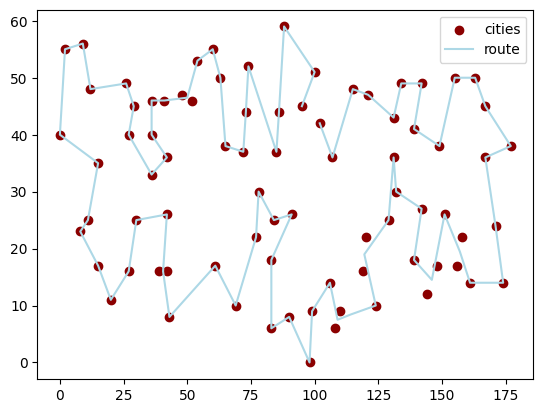

In [11]:
y = SOM_ETSP(X_cities, kernel_function=gaussian_kernel, alpha=1, gama=0.997, sigma=5, beta=0.982, M=81, seed=0, max_iter=10000)

The result isn't satisfying. There are some cities that are not covered.

## M = 2n

Stopped at iteration: 60
Route length: 736.3255482319412


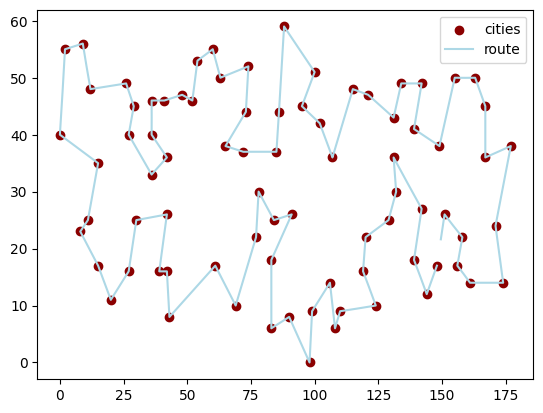

In [12]:
y = SOM_ETSP(X_cities, kernel_function=gaussian_kernel, alpha=0.8, gama=0.995, sigma=10, beta=0.945, M=81*2, seed=0, max_iter=1000)

All cities are covered, this can be used as a solution.

## M = 3n

Stopped at iteration: 244
Route length: 736.3479208756254


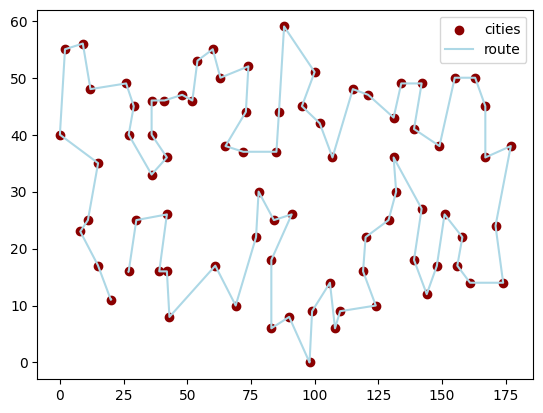

In [13]:
y = SOM_ETSP(X_cities, kernel_function=gaussian_kernel, alpha=0.75, gama=0.999, sigma=81*3, beta=0.975, M=81*3, seed=0, max_iter=500)

All cities are covered, this can be used as a solution.

## Best solution

Stopped at iteration: 60
Route length: 736.3255482319412


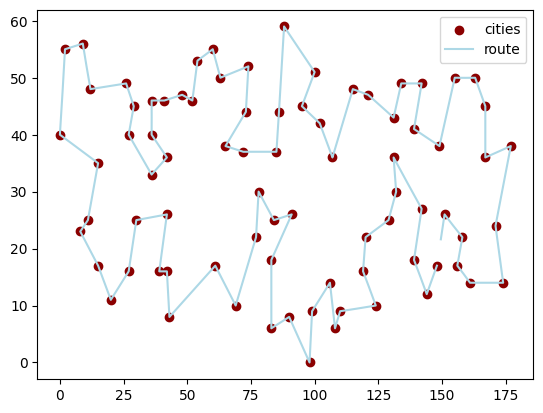

In [27]:
y_best = SOM_ETSP(X_cities, kernel_function=gaussian_kernel, alpha=0.8, gama=0.995, sigma=10, beta=0.945, M=81*2, seed=0, max_iter=1000)

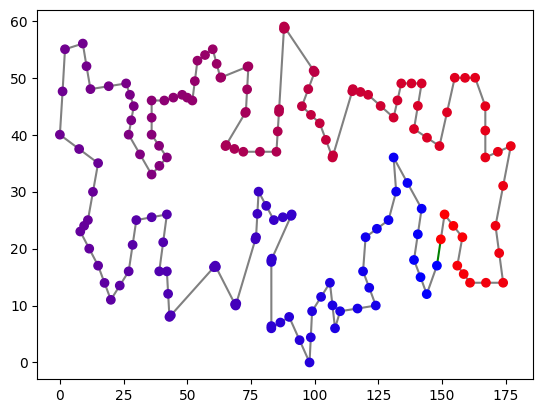

Route length: 736.3255482319412


In [28]:
plot_route(y_best)

# Elastic Band Kernel

## M = n

Stopped at iteration: 319
Route length: 713.3873220161616


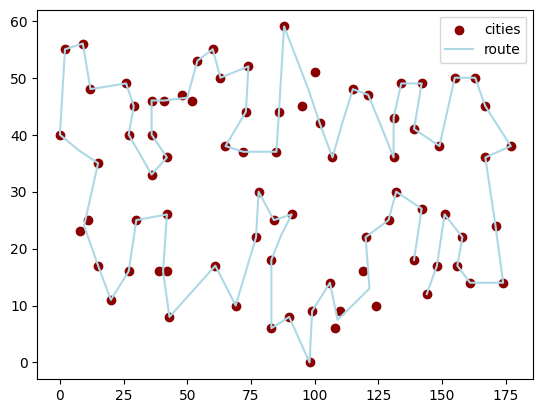

In [14]:
y = SOM_ETSP(X_cities, kernel_function=elastic_band_kernel, alpha=0.75, gama=0.99, sigma=81, beta=0.95, M=81, seed=0, max_iter=10000)

Some cities are not covered, not an acceptable solution.

## M = 2n

Stopped at iteration: 216
Route length: 728.3027556322063


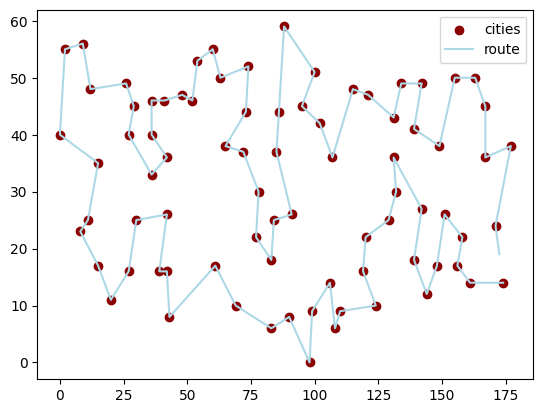

In [15]:
y = SOM_ETSP(X_cities, kernel_function=elastic_band_kernel, alpha=0.75, gama=0.995, sigma=10, beta=0.985, M=81*2, seed=0, max_iter=10000)

All cities are covered, this can be used as a solution.

## M = 3n

Stopped at iteration: 190
Route length: 737.4806692775311


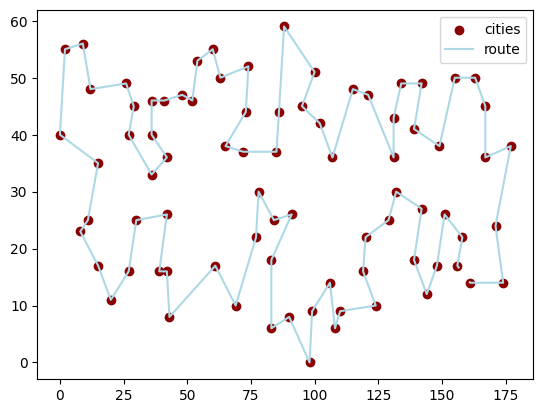

In [16]:
y1 = SOM_ETSP(X_cities, kernel_function=elastic_band_kernel, alpha=0.75, gama=0.99, sigma=25, beta=0.98, M=81*3, seed=0, max_iter=10000)

All cities are covered, this can be used as a solution.

## Best solution

Stopped at iteration: 216
Route length: 728.3027556322063


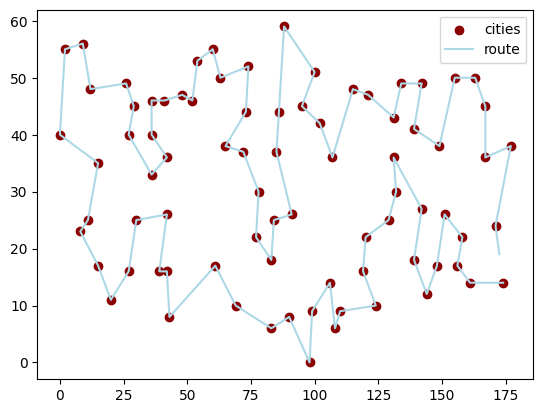

In [23]:
y_best = SOM_ETSP(X_cities, kernel_function=elastic_band_kernel, alpha=0.75, gama=0.995, sigma=10, beta=0.985, M=81*2, seed=0, max_iter=10000)

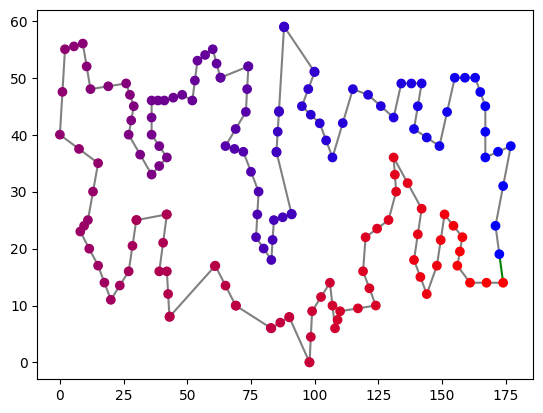

Route length: 728.3027556322063


In [25]:
plot_route(y_best)

### GIF

In [ ]:
gif_route(y_best, k=81*2)